[array([0.07840493, 0.36157423, 0.92904077]), array([ 0.25514995,  0.94712243, -0.19457029]), array([-0.87337122,  0.26797251,  0.40671052]), array([-0.13244544,  0.92146893,  0.3651756 ]), array([0.10077549, 0.66937209, 0.73606066]), array([0.49596124, 0.20388783, 0.84406884]), array([ 0.74596908, -0.66299963,  0.06294145]), array([-0.8620892,  0.3892116,  0.3245251]), array([ 0.65618636, -0.50805096, -0.55794594]), array([0.41577005, 0.69885372, 0.58201266]), array([ 0.63550776, -0.29643752, -0.71291983]), array([-0.21880445, -0.06036306,  0.97389985]), array([ 0.93262503, -0.35911192, -0.03534377]), array([ 0.40584205,  0.90529594, -0.12542529]), array([ 0.28129261,  0.44274337, -0.85138286]), array([ 0.07070775,  0.31525385, -0.9463696 ]), array([ 0.89483219,  0.05735225, -0.44270313]), array([-0.05010771,  0.41295646,  0.90937131]), array([0.52954976, 0.41319177, 0.74084385]), array([-0.41930382,  0.31241276, -0.85239813]), array([ 0.86833015,  0.27678579, -0.41157305]), array([ 0

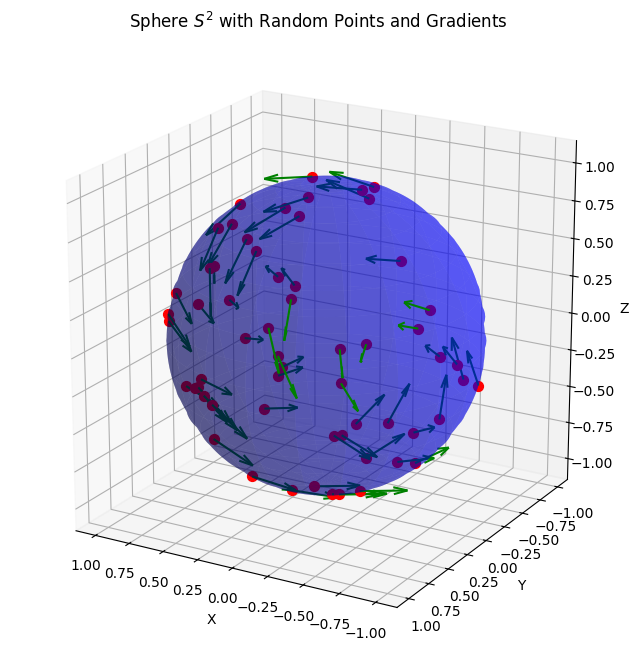

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


class SphereManifold:

  def __init__(self, n=3):
    """
      dim = n - 1
    """
    self.dim = n - 1

  def project_to_tangent_space(self, x, v):
    """
        Project a vector v onto the tangent space at point x on the sphere.
        This is done by subtracting the component of v that is parallel to x.
        """
    return v - np.dot(x, v) * x

  def retraction(self, x, eta):
    """
        Retract a tangent vector eta back to the sphere.
        This is done by moving in the direction of eta and then normalizing.
        """
    y = x + eta
    return y / np.linalg.norm(y)

  def gradient(self, f, x, eps=1e-8):
    """
        Compute the Riemannian gradient of a function f at point x on the sphere.
        The gradient is computed using central finite differences.
        """
    grad = np.zeros_like(x)
    for i in range(len(x)):
      e_i = np.zeros_like(x)
      e_i[i] = 1
      grad[i] = (f(x + eps * e_i) - f(x - eps * e_i)) / (2 * eps)
    return self.project_to_tangent_space(x, grad)

  def random_point(self):
    """
        Generate a random point on the sphere.
        """
    vec = np.random.randn(self.dim + 1)
    vec /= np.linalg.norm(vec, axis=0)
    return vec


  def random_dist(self):
    theta = np.random.uniform(0, 2 * np.pi)
    phi = np.random.uniform(0, np.pi)
    x = np.array([
        np.sin(phi) * np.cos(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(phi)
    ])
    return x


sphere = SphereManifold()

x = sphere.random_point()
y = sphere.random_point()

A2 = np.array([[1, 0], [0, -1]])
A3 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, -1]])


def quotient(x, A=A3):
  return x.T @ A @ x


def quadratic_function(x):
  return np.dot(x, x)


def grad(x,A=A3):
  return (np.eye(3) - x @ x.T) @ (2 * A @ x)


points = [sphere.random_point() for _ in range(60)]
print(points)
grads = [grad(x) for x in points]


def plot_sphere_with_gradients(points, gradients):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    x_sphere = np.outer(np.cos(u), np.sin(v))
    y_sphere = np.outer(np.sin(u), np.sin(v))
    z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot_surface(x_sphere, y_sphere, z_sphere, color='b', alpha=0.4, rstride=5, cstride=5, linewidth=0)

    
    for point, gradient in zip(points, gradients):
        ax.scatter(point[0], point[1], point[2], color='r', s=50)
        ax.quiver(point[0], point[1], point[2], gradient[0], gradient[1], gradient[2], color='g', length=0.3, normalize=True)

    ax.view_init(elev=20, azim=120)
    
    ax.set_title("Sphere $S^2$ with Random Points and Gradients")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect([1, 1, 1])

    plt.show()

# Generate and plot the points
plot_sphere_with_gradients(points, grads)


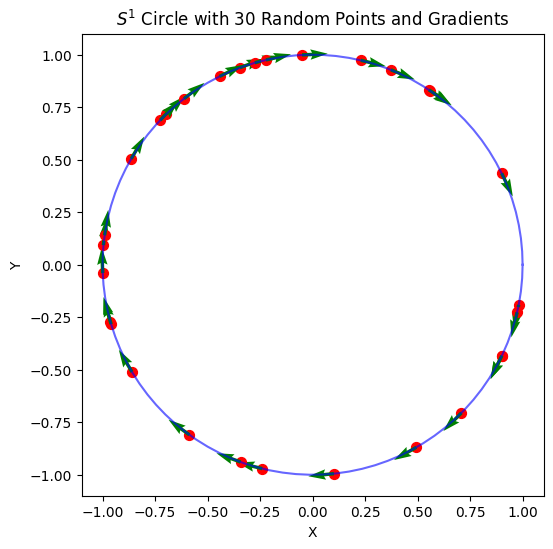

In [63]:
def quotient2(x, A=A2):
  return x.T @ A @ x


def quadratic_function(x):
  return np.dot(x, x)


def grad2(x,A=A2):
  return (np.eye(2) - x @ x.T) @ (2 * A @ x)

circle = SphereManifold(n = 2)

circle_points = [circle.random_point() for _ in range(30)]
circle_gradients = [grad2(x) for x in circle_points]

def plot_circle_with_gradients(points, gradients):
    theta = np.linspace(0, 2 * np.pi, 100)
    x_circle = np.cos(theta)
    y_circle = np.sin(theta)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(x_circle, y_circle, color='b', alpha=0.6)  # Circle

    for point, gradient in zip(points, gradients):
        ax.scatter(point[0], point[1], color='r', s=50)
        ax.quiver(point[0], point[1], gradient[0], gradient[1], color='g')

    ax.set_title("$S^1$ Circle with 30 Random Points and Gradients")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal', 'box')

    plt.show()

plot_circle_with_gradients(circle_points, circle_gradients)


## Stiefel Manifold

$$ St(n,p) = \{ X \in \mathbb{R}^{n \times p} \mid X^T X = I_p \} $$

In [20]:
from scipy.linalg import qr
def random_point(n,p):
  A = np.random.randn(n,p)
  Q,_ = qr(A)
  return Q

A = random_point(2,2)

def check_is_stiefel(X):
  size = X.shape[0]
  A = X.T @ X
  return np.allclose(A,np.eye(size),10e-3)

def project_to_tangent_space(X,Z):
  I = np.eye(X.shape[0])
  M = X.T @ Z
  skew = 1/2 * (M - M.T)
  proj = (I - X@X.T)@Z - X@skew
  return proj

B = np.eye(2)

C = project_to_tangent_space(A,B.T)

C

array([[ 1.11022302e-16, -1.42102144e-17],
       [-1.42102144e-17,  0.00000000e+00]])